# Image Classification Example
## Deep Model 2
### Amir 2022

In [1]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os
from numpy.random import seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
from tensorflow.random import set_seed
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [4]:
X = np.load('/content/gdrive/MyDrive/ANN/saved3512qX.npy')
y = np.load('/content/gdrive/MyDrive/ANN/saved3512qy.npy')

In [5]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (406, 512, 512, 3)
y_train shape:  (406, 3)
X_val shape  :  (102, 512, 512, 3)
y_val shape  :  (102, 3)
X_test shape :  (90, 512, 512, 3)
y_test shape :  (90, 3)


In [6]:
train_gen = ImageDataGenerator(horizontal_flip=True , rotation_range = 20)
validation_gen = ImageDataGenerator(horizontal_flip=True , rotation_range = 20)
train_gen.fit(X_train)
validation_gen.fit(X_val)

In [7]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    # x = data_augmentation(inputs)
    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    #x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)

In [8]:
model = make_model( input_shape=(512,512,3) )

In [9]:
#If you want to see the model summary, or even plot a model schema, you can use the functions presented below.

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [10]:
batch_size = 16
epochs = 60

In [11]:
model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/60
26/26 [==============================] - 28s 1s/step - loss: 0.2408 - accuracy: 0.9015 - val_loss: 2.3499 - val_accuracy: 0.4510
Epoch 2/60
26/26 [==============================] - 26s 996ms/step - loss: 0.2813 - accuracy: 0.8941 - val_loss: 2.7579 - val_accuracy: 0.4706
Epoch 3/60
26/26 [==============================] - 26s 996ms/step - loss: 0.2538 - accuracy: 0.8990 - val_loss: 2.5991 - val_accuracy: 0.4706
Epoch 4/60
26/26 [==============================] - 27s 1s/step - loss: 0.2222 - accuracy: 0.9089 - val_loss: 3.4034 - val_accuracy: 0.3824
Epoch 5/60
26/26 [==============================] - 26s 995ms/step - loss: 0.3048 - accuracy: 0.8818 - val_loss: 2.7825 - val_accuracy: 0.4118
Epoch 6/60
26/26 [==============================] - 26s 992ms/step - loss: 0.2682 - accuracy: 0.8867 - val_loss: 3.0025 - val_accuracy: 0.4706
Epoch 7/60
26/26 [==============================] - 26s 970ms/step - loss: 0.3099 - accuracy: 0.8645 - val_loss: 3.7024 - val_accuracy: 0.3824
Epoch

In [13]:
##model.fit( X_train, y_train, batch_size= batch_size, epochs = epochs)

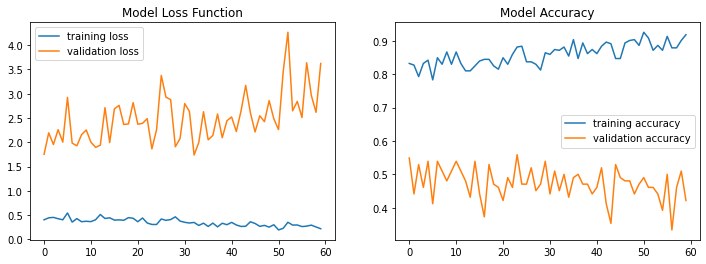

In [25]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_df['loss'], label='training loss')
plt.plot(history_df['val_loss'], label='validation loss')
plt.title('Model Loss Function')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_df['accuracy'], label='training accuracy')
plt.plot(history_df['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.legend()

3/3 [==============================] - 1s 422ms/step


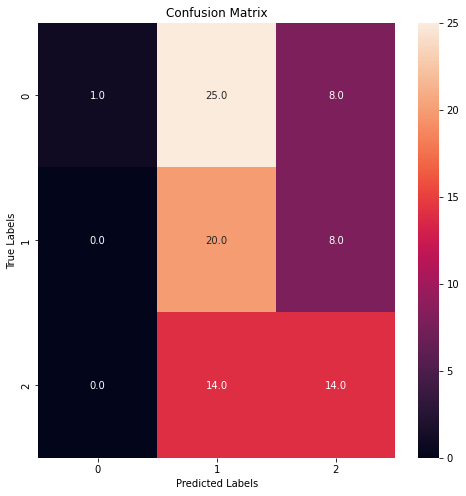

In [26]:
# Predicting labels from X_test data
y_pred = model.predict(X_test)
# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)
# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)
# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
print(classification_report(y_test_classes, y_pred_classes))
test_loss = model.evaluate(X_test, y_test)


              precision    recall  f1-score   support

           0       0.75      0.09      0.16        34
           1       0.34      0.89      0.50        28
           2       0.62      0.29      0.39        28

    accuracy                           0.40        90
   macro avg       0.57      0.42      0.35        90
weighted avg       0.58      0.40      0.34        90

3/3 [==============================] - 1s 379ms/step - loss: 2.4822 - accuracy: 0.4000


In [17]:
test_loss = model.evaluate(X_val, y_val)

4/4 [==============================] - 1s 305ms/step - loss: 2.2322 - accuracy: 0.4608


In [18]:
test_loss = model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 379ms/step - loss: 2.4822 - accuracy: 0.4000


In [27]:
confusion_matrix(y_test_classes, y_pred_classes)

array([[ 1, 25,  8],
       [ 0, 20,  8],
       [ 0, 14, 14]])

In [20]:
model.save('1_256_scratch')